# Image Clustering (using CNN)

* <b>Problem Statement</b>: You are provided with a dataset of ~5k 512x512 images, your program should accept an 512x512 input image and return N images from the provided dataset similar to the input image. To solve this problem, building an AutoEncoder model is recommended.
* <b>Dataset</b>: https://drive.google.com/file/d/1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri/view?usp=sharing
* <b>Evaluation Method</b>
    * Your code submission will be evaluated based code quality and on how accurate it is able to find similar images
        * simple score of C/N
        * C = no. of correct similar images returned
        * N = no. requested images

    * Plus points, for finding similar images with respect to unique feature
        * simple score of F/N
        * F = no. of images returned with the unique feature specific to the input image
        * N = no. requested images

    * Bonus points, if the provided dataset was clustered into K groups
    * Quality of Code based on Modularity, Reusability, Maintainability, Readability
    
* <b>Details</b>
    * Full Name : Sreeyapureddy Sai Srikar Reddy
    * Mail ID : saisrikarreddy98@gmail.com
    * Link to repository for code / Colab / script files uploads : https://github.com/SaiSrikarReddy/Avantari_Image_Clustering
    * Small documentation on procedure, coding stack followed : https://github.com/SaiSrikarReddy/Avantari_Image_Clustering/blob/master/Documentation_with_code.pdf

In [1]:
# Importing packages
from keras.preprocessing import image
import numpy as np
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import math
from collections import Counter 

In [2]:
# checking the image shape
import cv2
img_path = "../input/animal-faces/afhq/train/wild/flickr_wild_000003.jpg" 
img = cv2.imread(img_path)
print (img.shape)

(512, 512, 3)


## 1. Generating features from images using CNN

In [3]:
# CNN algorithm with 4 convolutional layers, 2 Max pooling layers, 2 Dropout layers and 2 Batch Normalization layers
def CNN_0():
    model = Sequential()
    model.add(Conv2D(24, kernel_size=(7,7),activation='relu',input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Conv2D(50, (5,5), activation='relu'))
    model.add(Conv2D(90,(5,5),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(120, (3,3), activation='relu'))
    return model

In [4]:
# Model summary
My_model = CNN_0()
My_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 218, 218, 24)      3552      
_________________________________________________________________
batch_normalization (BatchNo (None, 218, 218, 24)      96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 24)      0         
_________________________________________________________________
dropout (Dropout)            (None, 109, 109, 24)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 24)      96        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 105, 105, 50)      30050     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 101, 101, 90)      1

In [5]:
# https://stackoverflow.com/a/57451142/10348126   - A part of code is taken from this link
def creating_feature(file):
    img = image.load_img(file, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = img_data.astype('float32')
    img_data = img_data/255
    img_data = img_data.reshape(1,224,224,3)
    feature = My_model.predict(img_data)
    feature_np = np.array(feature)
    feature_list = (feature_np.flatten())
    return feature_list

In [6]:
# Generating features based on the CNN algorithm and Storing in a dictonary.
feature_list = []
check_list = {}
for dirname, _, filenames in os.walk('/kaggle/input/dataset'):
    for filename in tqdm(filenames):
        file = os.path.join(dirname, filename)
        file_name = file.split("/")[-1]
        feature_value = creating_feature(file)
        feature_list.append(feature_value)
        check_list[file_name] = feature_value

0it [00:00, ?it/s]
100%|██████████| 4738/4738 [03:30<00:00, 22.47it/s]


In [8]:
type(check_list)

dict

In [9]:
# length of each feature is 276480 after flatten and stored in the form of numpy array
print("Length:",len(check_list['0.jpg']))
print("Feature_map:", check_list['0.jpg'])

Length: 276480
Feature_map: [0.03127097 0.         0.         ... 0.         0.0300002  0.        ]


> **Test Image - 1328.jpg**  <br>
 > **Testing on sample image and finding similarity and displaying the top 15 similar images**

In [10]:
clustering_img_path = '../input/dataset/dataset/1328.jpg'
feature = creating_feature(clustering_img_path)
img = cv2.imread(clustering_img_path)

In [11]:
type(feature)

numpy.ndarray

 > Cosine similarity is to find the similarity between two features.<br>
 > If cosine similarity is high between two features then they are most likely to be same animal.

In [12]:
# https://stackoverflow.com/a/18424953/10348126
def cosine_similarity(v1,v2):
    "compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy)

In [13]:
def top_similarity(feature): 
    feature_check_list = {}
    for i in tqdm(check_list):
        obtained_feature = check_list[i]
        value = cosine_similarity(obtained_feature,feature)
        feature_check_list[i] = value
    #results = sorted([(key, value) for (key, value) in feature_check_list.items()], reverse = True)
    return feature_check_list

In [14]:
output_similarity = top_similarity(feature)

100%|██████████| 4738/4738 [46:30<00:00,  1.70it/s]


### > Sorting the top 15 images similar to test image

In [15]:
# Sorting the values in dictonary and picking the top 15 values
# https://www.geeksforgeeks.org/python-program-to-find-the-highest-3-values-in-a-dictionary/
k = Counter(output_similarity) 
high = k.most_common(15)  
for i in high: 
    print(i[0]," :",i[1]," ") 

1328.jpg  : 1.0  
3867.jpg  : 0.9560385266306173  
452.jpg  : 0.9540249541139376  
2491.jpg  : 0.9519551133889456  
1369.jpg  : 0.9510063452347932  
4636.jpg  : 0.9500390419133415  
4238.jpg  : 0.9498005329201525  
3520.jpg  : 0.9497633845228972  
1359.jpg  : 0.948889486635964  
3120.jpg  : 0.9488495721813585  
2909.jpg  : 0.9483349811329916  
1377.jpg  : 0.9480993996916315  
191.jpg  : 0.9477285193826422  
632.jpg  : 0.9472543933728574  
1220.jpg  : 0.9469315271470357  


### * Test Image

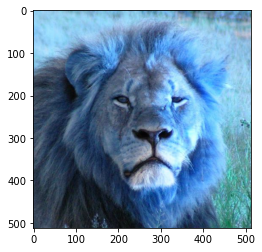

In [16]:
output = []
for i in high:
    output.append(cv2.imread('../input/dataset/dataset/'+ i[0]))
plt.imshow(output[0])

###  Output for the test image the top 15 similar images to the test image.

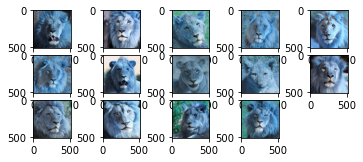

In [17]:
for i in range(1,len(output)):
    plt.subplot(5, 5, i)
    plt.imshow(output[i])
plt.show()

## 2. Clustering
###  Finding the optimal clusters

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil = []
kmax = 30

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(feature_list[:250])
    labels = kmeans.labels_
    sil.append(silhouette_score(feature_list[:250], labels, metric = 'euclidean'))

### The peak is at 7. So, the optimal clusters are 7

<function matplotlib.pyplot.show(*args, **kw)>

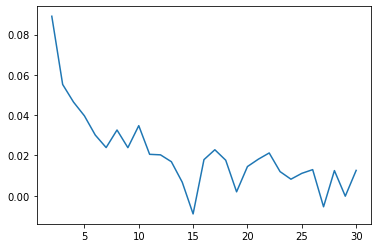

In [15]:
plt.plot(range(2,31), sil)
plt.show

### > As Kmeans clustering consumes most of the memory. A random sample of 250 images were clustered.

In [67]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 7).fit(feature_list[:250])
predict = kmeans.predict(feature_list[:250])
labels = kmeans.labels_

### > The Silhouette score is 0.045. That indicate overlapping clusters.
### > Less input data may be one of the reason for less score.

In [69]:
# https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
from sklearn import metrics
score = metrics.silhouette_score(feature_list[:250], labels, metric='euclidean')
print(score)

0.045191515


### > Storing the image names from check_list dictonary and storing in a dictonary.

In [64]:
Image_names = []
m = 0
for i in check_list:
    if m<250:
        Image_names.append(i)
        m = m + 1
        
print(len(Image_names), len(predict))

cluster_dict = {}
for i in range(0,250):
    cluster_dict[l[i]] = predict[i]

250 250


### > Flipping the keys and values, so that for each cluster there may be multiple images.
### > One key, multiple values like wise one cluster multiple images.

In [66]:
# https://www.geeksforgeeks.org/python-find-keys-with-duplicate-values-in-dictionary/
final_dict = {} 
  
for key, value in cluster_dict.items(): 
    if value not in final_dict: 
        final_dict[value] = [key] 
    else: 
        final_dict[value].append(key) 
print(final_dict[0])
print(final_dict[1])

['4642.jpg', '3680.jpg', '2026.jpg', '2434.jpg', '2349.jpg', '234.jpg', '2765.jpg', '4291.jpg', '3177.jpg', '3702.jpg', '2004.jpg', '1085.jpg', '765.jpg', '948.jpg', '70.jpg', '3398.jpg', '3781.jpg', '2310.jpg', '4237.jpg', '2111.jpg']
['1846.jpg', '2553.jpg', '2040.jpg', '2464.jpg', '2544.jpg', '3106.jpg', '3291.jpg', '138.jpg', '1217.jpg', '1382.jpg', '4688.jpg', '64.jpg', '4734.jpg', '1685.jpg', '53.jpg', '1089.jpg', '3764.jpg', '3845.jpg', '1041.jpg', '1721.jpg', '4271.jpg', '1891.jpg', '1415.jpg', '2502.jpg', '2055.jpg']


### > For each cluster 15 images are displayed accordingly.

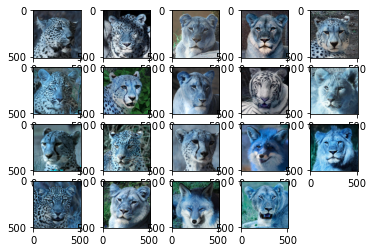

In [56]:
# cluster 0 
output = []
for i in final_dict[0][:20]:
    output.append(cv2.imread('../input/dataset/dataset/'+ i))
for i in range(1,len(output)):
    plt.subplot(4, 5, i)
    plt.imshow(output[i])
plt.show()

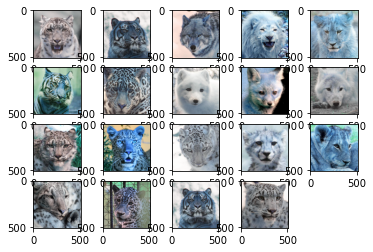

In [57]:
# cluster 1 
output = []
for i in final_dict[1][:20]:
    output.append(cv2.imread('../input/dataset/dataset/'+ i))
for i in range(1,len(output)):
    plt.subplot(4, 5, i)
    plt.imshow(output[i])
plt.show()

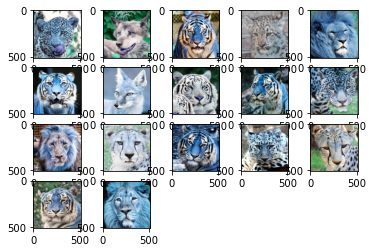

In [58]:
# cluster 2 
output = []
for i in final_dict[2][:20]:
    output.append(cv2.imread('../input/dataset/dataset/'+ i))
for i in range(1,len(output)):
    plt.subplot(4, 5, i)
    plt.imshow(output[i])
plt.show()

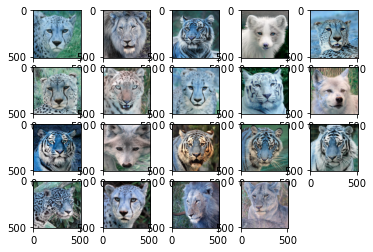

In [59]:
# cluster 3 
output = []
for i in final_dict[3][:20]:
    output.append(cv2.imread('../input/dataset/dataset/'+ i))
for i in range(1,len(output)):
    plt.subplot(4, 5, i)
    plt.imshow(output[i])
plt.show()

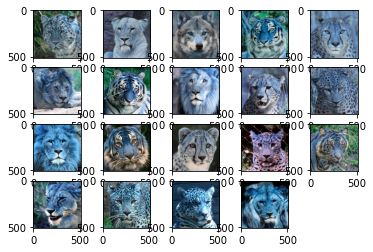

In [60]:
# cluster 4 
output = []
for i in final_dict[4][:20]:
    output.append(cv2.imread('../input/dataset/dataset/'+ i))
for i in range(1,len(output)):
    plt.subplot(4, 5, i)
    plt.imshow(output[i])
plt.show()

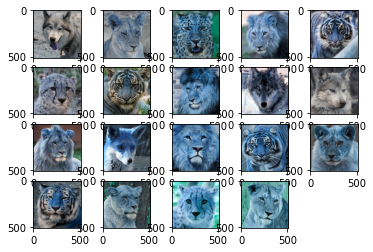

In [61]:
# cluster 5 
output = []
for i in final_dict[5][:20]:
    output.append(cv2.imread('../input/dataset/dataset/'+ i))
for i in range(1,len(output)):
    plt.subplot(4, 5, i)
    plt.imshow(output[i])
plt.show()

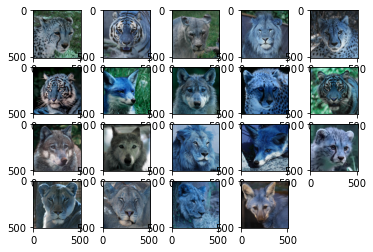

In [62]:
# cluster 6 
output = []
for i in final_dict[6][:20]:
    output.append(cv2.imread('../input/dataset/dataset/'+ i))
for i in range(1,len(output)):
    plt.subplot(4, 5, i)
    plt.imshow(output[i])
plt.show()

### > The accuracy is low in case of clustered outputs because of a small sample.

## References:

1. https://keras.io/
2. https://stackoverflow.com/a/57451142/10348126
3. https://stackoverflow.com/a/18424953/10348126
4. https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb
5. https://medium.com/@franky07724_57962/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1
6. https://www.geeksforgeeks.org/python-find-keys-with-duplicate-values-in-dictionary/
7. https://www.geeksforgeeks.org/python-program-to-find-the-highest-3-values-in-a-dictionary/
8. https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient